# Importing Libraries

In [1]:
# table manipulation, calculating
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100) # increase the maximum number of columns

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# scaling
from sklearn.preprocessing import StandardScaler

# learning
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
import lightgbm as lgb    
import xgboost as xgb
import catboost as cat

# Ignore all warnings
import warnings
warnings.simplefilter("ignore")

# Importing datasets

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

# EDA

## detail : https://www.kaggle.com/code/leonchani/eda-inspection-for-binary-prediction-with-rainfall

# Preprocessing

In [3]:
## KNN - Handling missing values
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df_test["winddirection"] = imputer.fit_transform(df_test[["winddirection"]])

# Feature Engineering

In [4]:
def generate_features(df):

    # time_series
    # lag feature
    for lag in [1, 3, 7, 14, 30]:
        df[f'cloud_lag_{lag}'] = df['cloud'].shift(lag)
        df[f'sunshine_lag_{lag}'] = df['sunshine'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag)

    ## amount of change
    df['cloud_change_1d'] = df['cloud'] - df['cloud'].shift(1)
    df['sunshine_change_1d'] = df['sunshine'] - df['sunshine'].shift(1)
    df['humidity_change_1d'] = df['humidity'] - df['humidity'].shift(1)

    # rate
    df['rate_maxtemp_temparature'] = df['maxtemp'] / df['temparature']
    df['rate_mintemp_temparature'] = df['mintemp'] / df['temparature']
    df['rate_maxtemp_mintemp_temparature'] = (df['maxtemp'] - df['mintemp']) / df['temparature']

    df['rate_maxtemp_mintemp_cloud'] = (df['maxtemp'] - df['mintemp']) * df['cloud']
    df['rate_maxtemp_mintemp_sunshine'] = (df['maxtemp'] - df['mintemp']) * df['sunshine']
    df['rate_maxtemp_mintemp_humidity'] = (df['maxtemp'] - df['mintemp']) * df['humidity']

    df['rate_maxtemp_mintemp_temparature_cloud'] = ((df['maxtemp'] - df['mintemp']) / (df['temparature']) * df['cloud'])
    df['rate_maxtemp_mintemp_temparature_sunshine'] = ((df['maxtemp'] - df['mintemp']) / (df['temparature']) * df['sunshine'])
    df['rate_maxtemp_mintemp_temparature_humidity'] = ((df['maxtemp'] - df['mintemp']) / (df['temparature']) * df['humidity'])
    
    # interaction
    # cloud
    # df['interaction_cloud_temperature'] = df['cloud'] * df['temparature']
    # df['interaction_cloud_mintemp'] = df['cloud'] * df['mintemp']
    # df['interaction_cloud_winddirection'] = df['cloud'] * df['winddirection']

    df['interaction_cloud_windspeed_sqrt'] = np.sqrt(df['cloud'] * df['windspeed'])
    df['interaction_cloud_temperature_sqrt'] = np.sqrt(df['cloud'] * df['temparature'])
    df['interaction_cloud_mintemp_sqrt'] = np.sqrt(df['cloud'] * df['mintemp'])
    df['interaction_cloud_winddirection_sqrt'] = np.sqrt(df['cloud'] * df['winddirection'])

    # df['interaction_cloud_temperature_log'] = np.log(df['cloud'] * df['temparature'])
    # df['interaction_cloud_mintemp_log'] = np.log(df['cloud'] * df['mintemp'])
    # df['interaction_cloud_winddirection_log'] = np.log(df['cloud'] * df['winddirection'])

    # sunshine
    # df['interaction_sunshine_temperature'] = df['sunshine'] * df['temparature']
    # df['interaction_sunshine_mintemp'] = df['sunshine'] * df['mintemp']
    # df['interaction_sunshine_winddirection'] = df['sunshine'] * df['winddirection']

    df['interaction_sunshine_windspeed_sqrt'] = np.sqrt(df['sunshine'] * df['windspeed'])
    df['interaction_sunshine_temperature_sqrt'] = np.sqrt(df['sunshine'] * df['temparature'])
    df['interaction_sunshine_mintemp_sqrt'] = np.sqrt(df['sunshine'] * df['mintemp'])
    df['interaction_sunshine_winddirection_sqrt'] = np.sqrt(df['sunshine'] * df['winddirection'])

    # df['interaction_sunshine_temperature_log'] = np.log(df['sunshine'] * df['temparature'])
    # df['interaction_sunshine_mintemp_log'] = np.log(df['sunshine'] * df['mintemp'])
    # df['interaction_sunshine_winddirection_log'] = np.log(df['sunshine'] * df['winddirection'])
    
    # humidity
    # df['interaction_humidity_temperature'] = df['humidity'] * df['temparature']
    # df['interaction_humidity_mintemp'] = df['humidity'] * df['mintemp']
    # df['interaction_humidity_winddirection'] = df['humidity'] * df['winddirection']

    df['interaction_humidity_windspeed_sqrt'] = np.sqrt(df['humidity'] * df['windspeed'])
    df['interaction_humidity_temperature_sqrt'] = np.sqrt(df['humidity'] * df['temparature'])
    df['interaction_humidity_mintemp_sqrt'] = np.sqrt(df['humidity'] * df['mintemp'])
    df['interaction_humidity_winddirection_sqrt'] = np.sqrt(df['humidity'] * df['winddirection'])

    # df['interaction_humidity_temperature_log'] = np.log(df['humidity'] * df['temparature'])
    # df['interaction_humidity_mintemp_log'] = np.log(df['humidity'] * df['mintemp'])
    # df['interaction_humidity_winddirection_log'] = np.log(df['humidity'] * df['winddirection'])

    # # univariable
    # ## Function to define wind direction
    # def get_wind_direction(degree):
    #     if 337.5 <= degree or degree < 22.5:
    #         return 1  # 'N'
    #     elif 22.5 <= degree < 67.5:
    #         return 2 # 'NE'
    #     elif 67.5 <= degree < 112.5:
    #         return 3 # 'E'
    #     elif 112.5 <= degree < 157.5:
    #         return 4 # 'SE'
    #     elif 157.5 <= degree < 202.5:
    #         return 5 # 'S'
    #     elif 202.5 <= degree < 247.5:
    #         return 6 # 'SW'
    #     elif 247.5 <= degree < 292.5:
    #         return 7 # 'W'
    #     else:
    #         return 8 # 'NW'
            
    # df['winddirection_flg'] = df['winddirection'].apply(get_wind_direction)
    # winddirection_dummies = pd.get_dummies(df['winddirection_flg'], prefix='winddirection').astype(int)
    # df = pd.concat([df, winddirection_dummies], axis=1)

    # df_grp_winddirection_flg_cloud = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['cloud'].mean().rename(columns={'cloud': 'mean_cloud'})
    # df_grp_winddirection_flg_sunshine = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['sunshine'].mean().rename(columns={'sunshine': 'mean_sunshine'})
    # df_grp_winddirection_flg_humidity = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['humidity'].mean().rename(columns={'humidity': 'mean_humidity'})
    # df_grp_winddirection_flg_temparature = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['temparature'].mean().rename(columns={'temparature': 'mean_temparature'})
    # df_grp_winddirection_flg_mintemp = df.groupby(['winddirection_flg'], as_index = False, dropna = False)['mintemp'].mean().rename(columns={'mintemp': 'mean_mintemp'})

    # df = pd.merge(df, df_grp_winddirection_flg_cloud, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_sunshine, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_humidity, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_temparature, on = 'winddirection_flg', how = 'inner')
    # df = pd.merge(df, df_grp_winddirection_flg_mintemp, on = 'winddirection_flg', how = 'inner') 

    # for stacking
    # df['cloud_flg'] = df['cloud'].apply(lambda x: 1 if x > 65 else 0)

    # df['gathing_weather'] = (df['cloud'] * 0.6) + (df['sunshine'] * 0.3) + (df['humidity'] * 0.1)

    # del df['cloud'] 
    # del df['sunshine']
    # del df['humidity']

    # df = df.drop(['winddirection_flg'], axis=1) # 不要な列を削除

    return df


In [5]:
df_train = generate_features(df_train)
df_test = generate_features(df_test)

# Modeling

In [6]:
SEED = 42
NUM_SPLITS = 10 # try different folds

In [7]:
# X = df_train.drop(columns=["rainfall", "day"])
X = df_train.drop(columns=["rainfall"])
y = df_train["rainfall"]

In [8]:
def get_model():
    from sklearn.ensemble import VotingClassifier
    import lightgbm as lgb
    import xgboost as xgb
    import catboost as cat
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 40,
        'max_depth': 10,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 1e-2,
        'verbosity': -1,
        'random_state': SEED
    }

    lgb_model = lgb.LGBMClassifier(**params)
    
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric="auc",
        tree_method="hist",
        n_estimators=100,
        learning_rate=0.01,
        max_leaves=31,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        random_state=SEED
    )
    
    cat_model = cat.CatBoostClassifier(
        iterations=500,
        eval_metric="AUC",
        loss_function="Logloss",
        verbose=0,
        learning_rate=0.01,
        l2_leaf_reg=0.2,
        subsample=0.50,
        max_bin=4096,
    )
    
    return VotingClassifier(
                 estimators=[('lgb', lgb_model),
                             ('xgb', xgb_model),
                             ('cat', cat_model)
                            ],
                 voting='soft'
            )

In [9]:
# Training
model = get_model()
model.fit(X, y)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.8,
                                             bagging_freq=1,
                                             feature_fraction=0.8,
                                             lambda_l1=0.1, lambda_l2=0.1,
                                             learning_rate=0.01, max_depth=10,
                                             metric='auc', min_data_in_leaf=50,
                                             min_sum_hessian_in_leaf=0.01,
                                             num_leaves=40, objective='binary',
                                             random_state=42, verbosity=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callba...
                                            learning_rate=0.01, max_bin=4096,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=31,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=2,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7cba2d20c340>)],
                 voting='soft')

# Select Features

## feature_importance

,Feature,LightGBM,XGBoost,CatBoost,Average
8,cloud,22466.852479,83.868248,10.969897,7520.563541
9,sunshine,3277.155524,28.706282,2.742899,1102.868235
41,interaction_cloud_mintemp_sqrt,2252.187884,14.890791,3.376909,756.818528
37,rate_maxtemp_mintemp_temparature_sunshine,1728.380942,31.930231,2.380675,587.563949
40,interaction_cloud_temperature_sqrt,1711.345799,23.076109,4.219229,579.547046
7,humidity,942.274701,13.750641,3.776869,319.934070
46,interaction_sunshine_winddirection_sqrt,441.490452,7.344553,2.328169,150.387725
27,cloud_change_1d,378.487815,10.817090,1.626522,130.310476
6,dewpoint,364.584238,4.597851,2.385586,123.855892
34,rate_maxtemp_mintemp_sunshine,332.629308,13.216456,2.393872,116.079879


,Feature,LightGBM,XGBoost,CatBoost,Average
8,cloud,6.939379,6.134432,6.089555,6.937922
9,sunshine,0.801860,1.659048,0.528657,0.805340
41,interaction_cloud_mintemp_sqrt,0.474040,0.538174,0.957205,0.474664
37,rate_maxtemp_mintemp_temparature_sunshine,0.306509,1.920613,0.283818,0.312928
40,interaction_cloud_temperature_sqrt,0.301061,1.202263,1.526557,0.305268
7,humidity,0.055085,0.445672,1.227552,0.057188
46,interaction_sunshine_winddirection_sqrt,-0.105082,-0.074065,0.248327,-0.104826
27,cloud_change_1d,-0.125233,0.207668,-0.225939,-0.124011
6,dewpoint,-0.129680,-0.296909,0.287137,-0.130179
34,rate_maxtemp_mintemp_sunshine,-0.139900,0.402333,0.292738,-0.137610


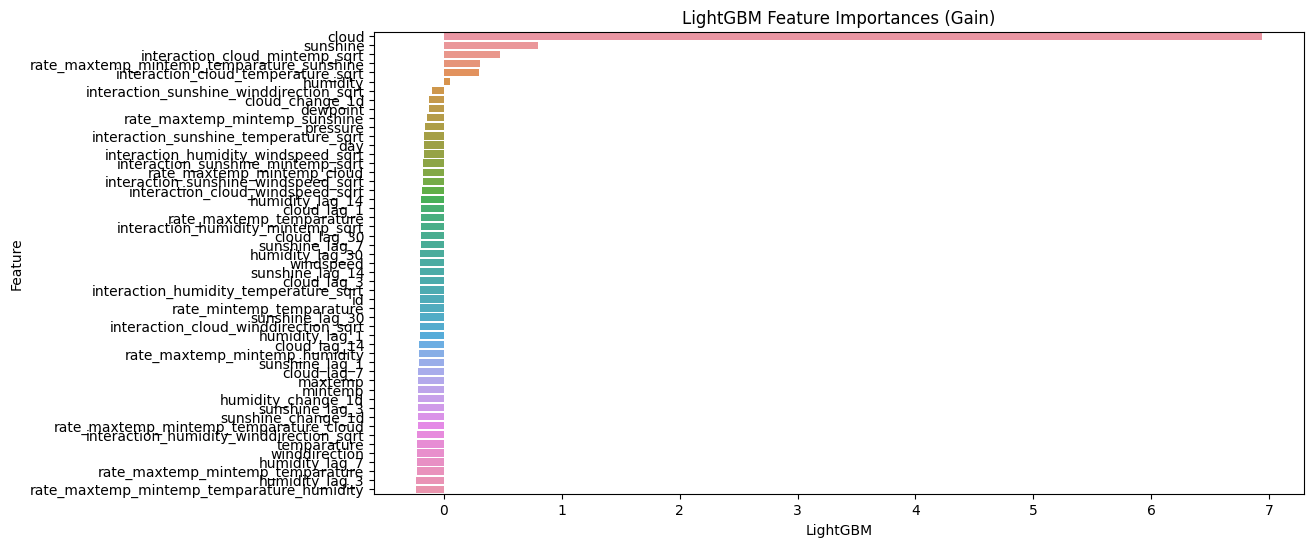

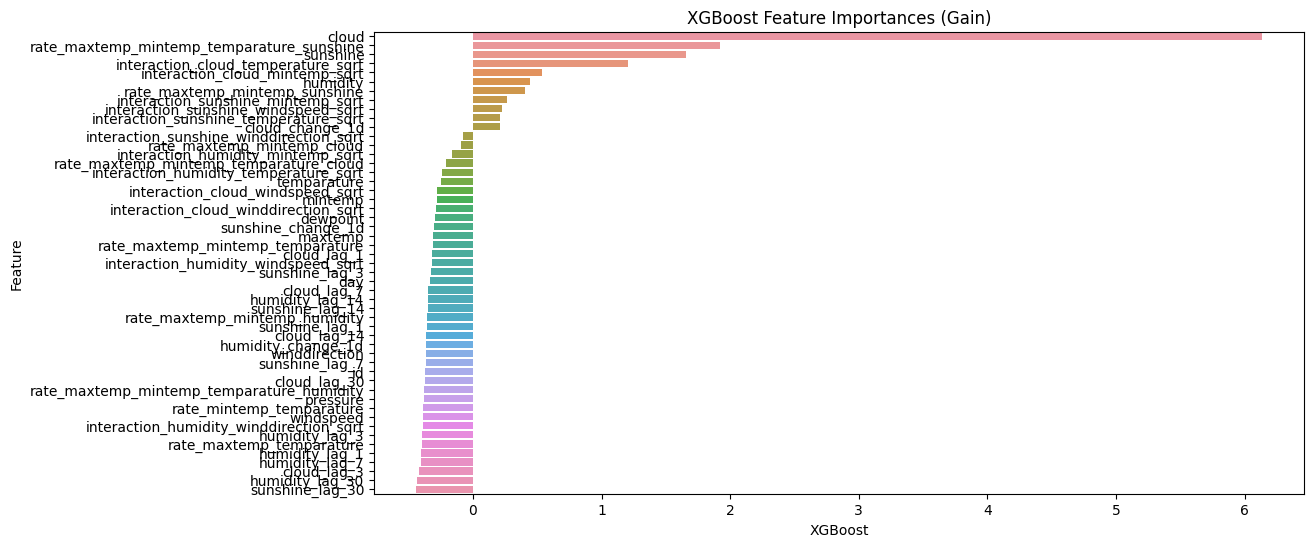

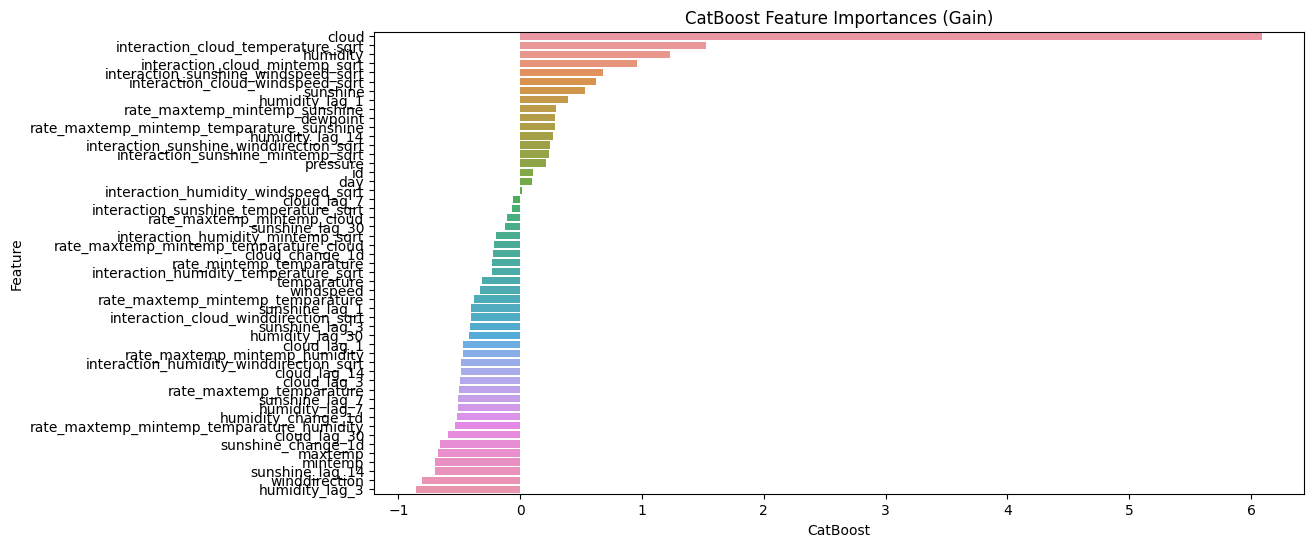

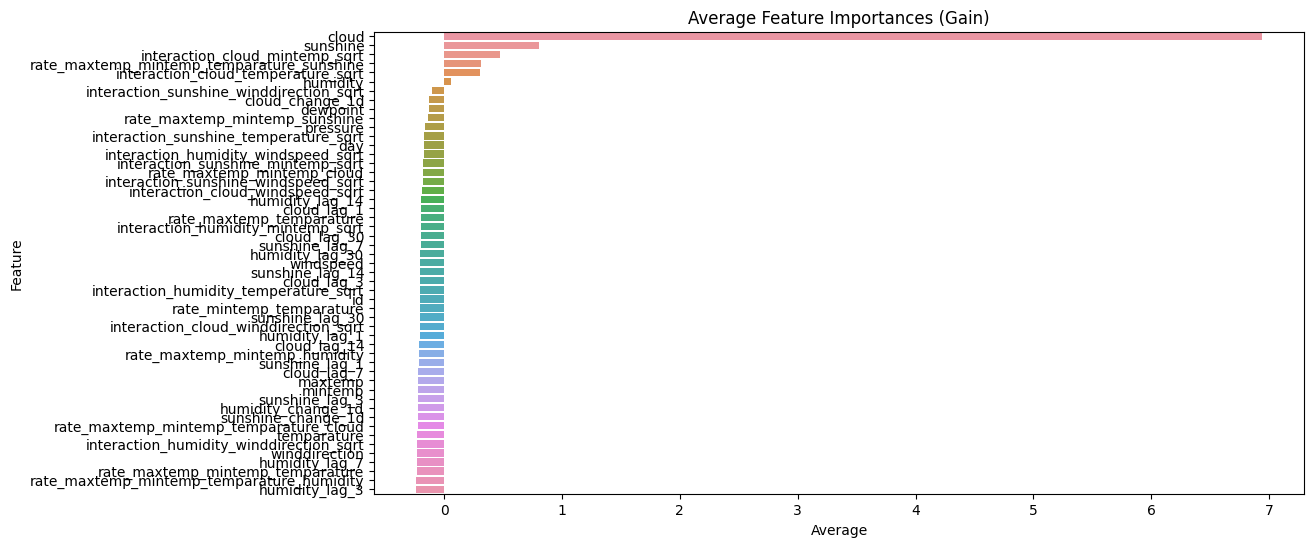

In [10]:
# Get the importance of each model's features using gain
lgb_importances = model.estimators_[0].booster_.feature_importance(importance_type='gain')
xgb_importances = model.estimators_[1].get_booster().get_score(importance_type='gain')
cat_importances = model.estimators_[2].get_feature_importance(type='FeatureImportance')

# Get the feature names (using the column names of X)
feature_names = X.columns
xgb_importances_list = [xgb_importances.get(f, 0) for f in feature_names]

# Summarize feature importance in a DataFrame
df_importances = pd.DataFrame({
    'Feature': feature_names,
    'LightGBM': lgb_importances,
    'XGBoost': xgb_importances_list,
    'CatBoost': cat_importances
})

# Averaging feature importance (optional), may not be very useful
# (If they were the same model, it would make a lot of sense, but they are in different orders of magnitude, so I can't really say. Should we standardize it?)
df_importances['Average'] = df_importances[['LightGBM', 'XGBoost', 'CatBoost']].mean(axis=1)
display(df_importances.sort_values(by='Average', ascending=False)) # Since the gain values ​​are different here, standardization is used to align the scales.

# Select a column of numeric type
numeric_cols = df_importances.select_dtypes(include=np.number).columns
df_numeric = df_importances[numeric_cols]

# Standardization (Does this help us to determine which variables are effective for prediction? Or does it help us to determine whether we are overfitting at this stage?)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(X_scaled, columns=numeric_cols)
df_feature = df_importances[["Feature"]]
df_importances = pd.concat([df_feature, df_scaled], axis=1)
display(df_importances.sort_values(by='Average', ascending=False))

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='LightGBM', y='Feature', data=df_importances.sort_values(by='LightGBM', ascending=False))
plt.title('LightGBM Feature Importances (Gain)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='XGBoost', y='Feature', data=df_importances.sort_values(by='XGBoost', ascending=False))
plt.title('XGBoost Feature Importances (Gain)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='CatBoost', y='Feature', data=df_importances.sort_values(by='CatBoost', ascending=False))
plt.title('CatBoost Feature Importances (Gain)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Average', y='Feature', data=df_importances.sort_values(by='Average', ascending=False))
plt.title('Average Feature Importances (Gain)')
plt.show()


## SHAP

In [11]:
import shap

# LGBM SHAP values
explainer_lgb = shap.TreeExplainer(model.estimators_[0])
shap_values_lgb = explainer_lgb.shap_values(X)

# XGB SHAP values
explainer_xgb = shap.TreeExplainer(model.estimators_[1])
shap_values_xgb = explainer_xgb.shap_values(X)

# CatBoost SHAP values
explainer_cat = shap.TreeExplainer(model.estimators_[2])
shap_values_cat = explainer_cat.shap_values(X)

In [12]:
# Averaging SHAP values
shap_values_mean = (
    shap_values_lgb + shap_values_xgb + shap_values_cat
) / 3

In [13]:
shap_values_mean = np.mean(shap_values_mean, axis=0)

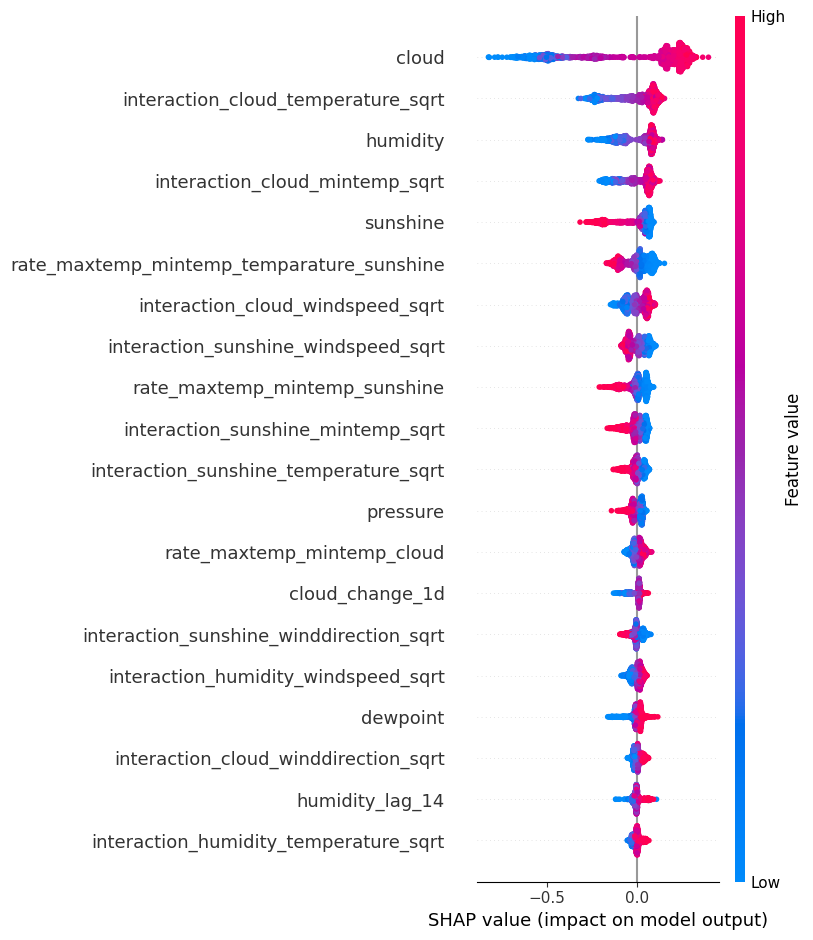

In [14]:
shap.summary_plot(shap_values_mean, X)

In [15]:
# If shap_values_lgb is a list, convert it to a NumPy array
if isinstance(shap_values_lgb, list):
    shap_values_lgb = np.array(shap_values_lgb)

# Handling the multiclass classification case
if len(shap_values_lgb.shape) == 3:
    shap_importance = np.abs(shap_values_lgb).mean(axis=1).mean(axis=0)
# Handling binary classification cases
else:
    shap_importance = np.abs(shap_values_lgb).mean(axis=0)

# Store in DataFrame
df_importance = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': shap_importance
})

# Sort by importance
df_importance = df_importance.sort_values('shap_importance', ascending=False)
display(df_importance)

,feature,shap_importance
8,cloud,0.518871
41,interaction_cloud_mintemp_sqrt,0.102551
7,humidity,0.082671
9,sunshine,0.076269
40,interaction_cloud_temperature_sqrt,0.066961
37,rate_maxtemp_mintemp_temparature_sunshine,0.053658
6,dewpoint,0.024469
2,pressure,0.024192
47,interaction_humidity_windspeed_sqrt,0.022573
39,interaction_cloud_windspeed_sqrt,0.017174


In [16]:
# # If you were to select the features, it would look something like this
# df_importance = pd.DataFrame({
#     'feature': X.columns,
#     'shap_importance': np.abs(shap_values_mean).mean(axis=0)
# })

# ### sort
# df_importance = df_importance.sort_values('shap_importance', ascending=False)

# # Select the top 20 features
# selected_features = df_importance['feature'].iloc[:20].tolist()

# # Top N%
# # df_importance = df_importance[df_importance["shap_importance"]>=0.01]
# # selected_features = df_importance['feature'].tolist()
# # selected_features

# # Recreate the trainig data by narrowing down the features
# X = df_train[selected_features]

# Cross Validation

In [17]:
cv = KFold(n_splits=NUM_SPLITS, random_state=SEED, shuffle=True)
scores = []
models = []

for fold, (train_index, valid_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_val = y.iloc[train_index], y.iloc[valid_index]

    # Modeling
    model = get_model()
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_val = model.predict_proba(X_val)[:, 1]
    
    score = roc_auc_score(y_val, y_pred_val)
    
    scores.append(score)
    models.append(model)


In [18]:
model

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.8,
                                             bagging_freq=1,
                                             feature_fraction=0.8,
                                             lambda_l1=0.1, lambda_l2=0.1,
                                             learning_rate=0.01, max_depth=10,
                                             metric='auc', min_data_in_leaf=50,
                                             min_sum_hessian_in_leaf=0.01,
                                             num_leaves=40, objective='binary',
                                             random_state=42, verbosity=-1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callba...
                                            learning_rate=0.01, max_bin=4096,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=31,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=2,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7cb93489b6a0>)],
                 voting='soft')

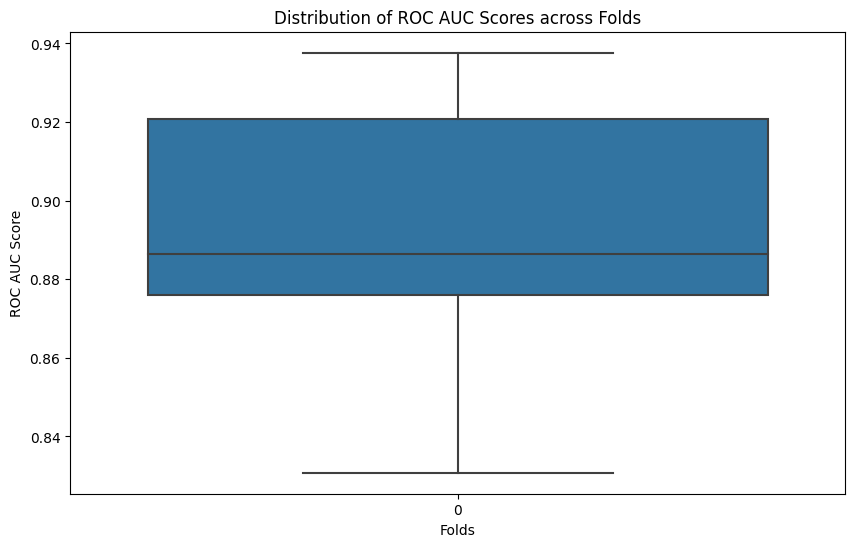

Scores: [0.8307768431469569, 0.8879440665154951, 0.9013157894736843, 0.8750942447851218, 0.9272561945896796, 0.8594325319471519, 0.9351479289940828, 0.937632135306554, 0.8848151848151848, 0.8782838983050848]


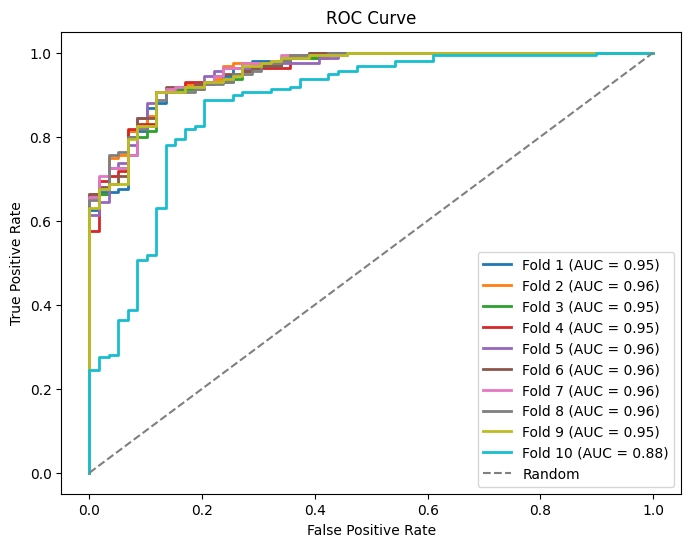

Cross-validated ROC AUC score: 0.89177 +/- 0.03259


In [19]:
# Visualize the scores of each fold with box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores)
plt.title('Distribution of ROC AUC Scores across Folds')
plt.xlabel('Folds')
plt.ylabel('ROC AUC Score')
plt.show()

# Display the scores of each fold in a list
print("Scores:", scores)

# Plot the ROC curve for each fold
plt.figure(figsize=(8, 6))
for fold, model in enumerate(models):
    y_pred_val = model.predict_proba(X.iloc[valid_index])[:, 1]
    fpr, tpr, thresholds = roc_curve(y.iloc[valid_index], y_pred_val)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')

# diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Graph settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Shows the mean and standard deviation of AUC scores
print(f'Cross-validated ROC AUC score: {np.mean(scores):.5f} +/- {np.std(scores):.5f}') 

# Prediction

In [20]:
test_id = df_test["id"]
# test = df_test.drop(columns=["day"])
# test = df_test[selected_features]
test = df_test
submit_score = []

for fold_, model in enumerate(models):
    # predict test data
    pred_ = model.predict_proba(test)[:, 1]
    submit_score.append(pred_)

# predict test data
pred = np.mean(submit_score, axis=0)

# Submission

In [21]:
submission = pd.DataFrame({
    'id': test_id,
    'rainfall': pred
})

# Save
submission.to_csv('submission.csv', index=False)

submission

,id,rainfall
0,2190,0.905448
1,2191,0.918789
2,2192,0.870757
3,2193,0.341386
4,2194,0.323195
...,...,...
725,2915,0.913666
726,2916,0.796978
727,2917,0.905259
728,2918,0.919774
